# Car-Sharing Service

Let's imagine a car-sharing service using Shared Autonomous Vehicles (SAVs) operating in Toronto.

Under this SAV model, The car-sharing platform would dispatch its autonomous vehicles from **depots** to **pickup locations**, driving the passenger to a **dropoff location**, and then proceeding either to the next passenger, or returning to the depot.

Let's define the following parameters to our example problem:

1. Let's assume there are 10 vehicle depots scattered around the city of Toronto.
2. There are also 10 passengers at different locations all waiting for an SAV.
3. The goal is to assign vehicles to passengers in such a way to optmize for some constraints.

Additionally, let's consider the following:
* Each SAV can seat 4 passengers, so multipassenger trips may be possible.
* Each depot  can only accomodate one SAV at a time.
* Gas costs 0.3 per unit of distance.
* SAVs earn 0.8 per unit of distance.

For this example, we'll implement GA. For the time being, we'll also limit trips to single passenger only; this simplifies the solution.

In [98]:
import pandas as pd
from smart_mobility_utilities.poi import poi

# Import location data
depots = pd.read_csv("carshare/carshare_depot.csv")
depot_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in depots.iterrows()]
pickups = pd.read_csv("carshare/carshare_origin.csv")
pickup_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in pickups.iterrows()]
dropoffs = pd.read_csv("carshare/carshare_dest.csv")
dropoff_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in dropoffs.iterrows()]

## Utility Functions

First, let's define some useful functions that will be used in our implementation.

### Crossover and Mutation
We will use an Order 1 Crossover with a Swap Mutation for this implementation.

In [2]:
from smart_mobility_utilities.problem import ordOne_crossover, swap_mutation

### Distance
We can define the distance from one stop to the next as simply the driving distance, as calculated by `osrm`. 

In [3]:
from smart_mobility_utilities.poi import poi
def distance(start,end):
    # We can use the poi class that depends on osrm routing between two nodes
    return start.route_to(end)['length']

Instead of calculating the distances on the fly, we can store these distances in a trip matrix, as `osrm` is rather slow.

In [4]:
tm = pd.read_csv("carshare/trip_matrix.csv").values
trip_matrix = {}
all_points = depot_nodes + pickup_nodes + dropoff_nodes
for point in all_points:
    i = all_points.index(point)
    trip_matrix[point] = {}
    for point2 in all_points:
        j = all_points.index(point2)
        trip_matrix[point][point2] = tm[i][j+1]

### Random Solution Generation
We can generate a random "solution" by defining the number of passengers it needs to serve.

In [87]:
from copy import deepcopy
def find_depots(route, depots, pre_avoid=[], post_avoid=[]): 
    start = route[0]
    end = route[-1]
    depots = deepcopy(depots)
    tmp_depots = deepcopy(depots)
    [depots.pop(depots.index(x)) for x in pre_avoid if x in depots]
    distances_to_start = [trip_matrix[x][start] for x in depots]
    [depots.pop(depots.index(x)) for x in post_avoid if x in depots]
    distances_from_end = [trip_matrix[end][x] for x in depots]
    start_depot = tmp_depots[distances_to_start.index(min(distances_to_start))]
    end_depot = tmp_depots[distances_from_end.index(min(distances_from_end))]
    route = [start_depot] + route + [end_depot]
    return route

In [26]:
import random

def random_solution(depots,pickups, pre_avoid=[], post_avoid=[]):
    route = []
    can_visit = deepcopy(pickups)
    for i in range(len(pickups)):
        # select a random pickup location
        random_pickup = random.choice(can_visit)
        route.append(random_pickup)
        can_visit.pop(can_visit.index(random_pickup))
        
    # now we can choose the depot closest to starting and ending locations
    route = find_depots(route, depots, pre_avoid, post_avoid)
    return route
            

### Fitness

We can define the fitness of a solution in terms of its real world cost. Since the only cost provided above is the cost of gas, which is directly related to distance travelled, we can consider total fleet distance as a variable to minimize. It may also be interesting to minimize overall mileage on the fleet for the purposes of maintenance, but this too is essentially a minimization of total fleet distance.

Let's assume that the **number** of vehicles is not a cost driver. That is to say, driving 4 km on one vehicle is more costly than driving 1 km on two vehicles, and equivalent to driving 2 km on two vehicles. This favours using more vehicles whenever convenient, which also minimizes passengers per vehicle (the maximum is 4 per vehicle, but maybe we prefer less?).

To that end, the cost of driving is as follows:

$ C = g \times \sum_{n=1}^{N} \sum_{j=1}^{S_n} \sum_{k=1}^{len(S_n)-1} distance(S_n^k,S_n^{k+1})$

Where
* $N=$ total number of vehicles being used
* $S_n=$ list of stops for vehicle $n$, where $S_n^k$ is the $k$ th stop for vehicle $n$
* $g=$ the cost of fuel per distance

However, we also *earn* money from driving, as long as we have a passenger in the vehicle. This means:

$ R = r \times \sum_{n=1}^{N} \sum_{j=1}^{S_n} \sum_{k=1}^{len(S_n)-1} distance(S_n^k,S_n^{k+1})$

Where
* $N=$ total number of vehicles being used
* $S_n=$ list of stops for vehicle $n$, where $S_n^k$ is the $k$ th stop for vehicle $n$ **AND** $S_n^k$ is a pickup, and $S_n^{k+1}$ is a dropoff. This means we *don't* make money when the car is going from dropoff to the next pickup, and we don't make money to and from the depots.
* $g=$ the cost of fuel per distance

Profit is the calculated as being $P=R-C$

In [7]:
def expand_route(route, pickups, dropoffs):
    actual_route = []
    for stop in route:
        if stop not in pickups:
            # It is a depot
            actual_route.append(stop)
            continue
        actual_route.append(stop)
        drop = dropoffs[pickups.index(stop)]
        actual_route.append(drop)
    return actual_route

In [8]:
def fitness(solutions, trip_matrix):
    result = []
    for vehicle_route in solutions:
        # We need to expand the routes into pickup-dropoffs to calculate actual cost
        expanded_route = expand_route(vehicle_route, pickup_nodes, dropoff_nodes)
        total = 0
        for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
            if stop in pickup_nodes and next_stop in dropoff_nodes:
                cost_factor = 0.5
            else:
                cost_factor = -0.3
            total += cost_factor * trip_matrix[stop][next_stop]
        result.append(total)
    return result

## Solution using Genetic Algorithm (Single Vehicle)

In [99]:
# Initialize some parameters
pop_size = 16
iterations = 1000
num_parents = 8
mutation_prob = 0.3
crossover_prob = 0.7

The problem can be further defined as a problem of passenger allocation. For a one-vehicle solution, all 17 passengers are allocated to the lone vehicle. In this case, the vehicle must find the shortest route from the first depot, through all 17 pickup and dropoff locations, and finally back to a depot.

In [100]:
# Generate initial population
population = [random_solution(depot_nodes,pickup_nodes) for _ in range(pop_size)]
costs = fitness(population, trip_matrix)
costs

[4864.610000000001,
 5256.620000000003,
 7491.110000000001,
 4876.970000000002,
 11779.279999999999,
 729.3800000000007,
 4315.28,
 4973.779999999999,
 12083.689999999999,
 6690.920000000004,
 3960.5900000000024,
 6371.120000000001,
 3442.8200000000006,
 1932.2299999999998,
 144.35000000000218,
 4644.110000000001]

In [101]:
from heapq import nlargest

def optimize_route(population, trip_matrix):
    states = []
    # The main genetic algorithm
    for _ in range(iterations):
        costs = fitness(population, trip_matrix)
        states.append(max(costs))
        # Select the parents, we want to maximize the profit
        parents = nlargest(num_parents,population, key=lambda x: costs[population.index(x)])
        # Need to remove depots from the routes
        parents = [x[1:-1] for x in parents]
        offspring = []
        new_population = []
        for p1, p2 in zip(parents[:len(parents)//2],parents[len(parents)//2:]):
            # Crossover probability
            if random.random() < crossover_prob:
                offspring.append(ordOne_crossover(p1,p2))
                offspring.append(ordOne_crossover(p2,p1))
            else:
                offspring.append(p1)
                offspring.append(p2)
        for child in offspring:
            if random.random() < mutation_prob:
                new_population.append(swap_mutation(child))
            else:
                new_population.append(child)
        new_population.extend(parents)
        population = [find_depots(route, depot_nodes) for route in new_population]
    return population, states

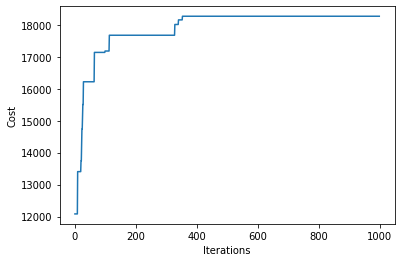

In [102]:
import matplotlib.pyplot as plt
population, states = optimize_route(population, trip_matrix)
plt.plot(states)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

In [103]:
costs = fitness(population, trip_matrix)
route = max(population,key= lambda x: costs[population.index(x)])
print("Profit of route:", costs[population.index(route)])
# expand the route
route = expand_route(route,pickup_nodes,dropoff_nodes)

from smart_mobility_utilities.poi import drawRouteOrder
# define marker colors
colors = []
for stop in route:
    if stop in depot_nodes:
        colors.append('blue')
    if stop in pickup_nodes:
        colors.append('green')
    if stop in dropoff_nodes:
        colors.append('red')
drawRouteOrder([x.coordinates[::-1] for x in route],route,range(1,len(route)+1), colors=colors)



Profit of route: 18265.37


As you can see, this solution prioritizes finding pickup locations that are close to previous dropoff locations, thus minimizing time driving without a passenger.

## Try it yourself
As an project, you may wish to consider an implementation using more than one vehicle. In this case, we must optimize the profits by first allocating the trips to each vehicle (this itself is an optimization problem), and then optimizing the order of the stops within each vehicle's route. It may be easier to simplify the allocation step, such as allocating them based on order receiving time (first come first serve), geographic location (clustering), or simply optimizing the route as a whole and splitting the route up and dispatching vehicles from depots that lie on the route.

If you come up with an interesting implementation, feel free to submit an pull request on Github!